# Simulating optimized cells in Arbor and cross-validation with Neuron

This notebook demonstrates how to run a simulation of a simple single compartmental cell with fixed/optimized parameters in Arbor. We follow the standard BluePyOpt flow of setting up an electrophysiological experiment and export the cell model to a mixed JSON/ACC-format. We then cross-validate voltage traces obtained with Arbor with those from a Neuron simulation.

In [ ]:
# Install matplotlib if needed
!pip install matplotlib

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload

First we need to import the module that contains all the functionality to create electrical cell models

In [3]:
import bluepyopt as bpop
import bluepyopt.ephys as ephys

In [4]:
import os
import tempfile
import numpy
import pandas
import arbor

If you want to see a lot of information about the internals, 
the verbose level can be set to 'debug' by commenting out
the following lines

In [5]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## Setting up the cell model

We use a single-compartimental cell model with the same morphology and mechanisms as in `simplecell.ipynb` that can be instantiated with different options for axon replacement policy and mechanism parameter values.

In [6]:
import simplecell_model  # enables simplecell_model.create(do_replace_axon=...)

## Creating the protocols

A protocol consists of a set of stimuli, and a set of responses (i.e. recordings). These responses will later be used to compare voltage traces from simulations between Arbor and Neuron for different parameter values and axon replacement configurations.

Let's create two protocols, two square current pulses injected centrally at the soma with different amplitudes and a slightly displaced probe location.

In [7]:
# Define locations on branch 0 of the morphology (soma)
location_defs = dict(stim_site='(location 0 0.5)',
                     probe_site='(location 0 0.75)')

# Make location available to Arbor through a callback
def instantiate_locations(labels):
    labels.append(arbor.label_dict(location_defs))

In [8]:
soma_loc = ephys.locations.NrnSeclistCompLocation(
        name='soma',
        seclist_name='somatic',
        sec_index=0,
        comp_x=0.5)

probe_loc = ephys.locations.NrnSeclistCompLocation(
        name='probe',
        seclist_name='somatic',
        sec_index=0,
        comp_x=0.75)


and then the stimuli, recordings and protocols. For each protocol we add a recording and a stimulus in the soma.

In [9]:
# Protocol prots configuration
protocol_steps = []
for name, amplitude in [('step1', 0.01), ('step2', 0.05)]:
    protocol_steps.append(dict(name=name,
                               amplitude=amplitude,
                               delay=100,
                               duration=50,
                               total_duration=200,
                               recording_name='%s.soma.v' % name))

We make current stimuli, voltage and spike recordings available to Arbor through callbacks

In [10]:
# Current stimuli
def instantiate_stimuli(decor, step):
    decor.place('"stim_site"',
                arbor.iclamp(step['delay'], step['duration'], current=step['amplitude']),
                step['name'])

# Spike detection with a voltage threshold of -10 mV
# (different from spike_time observables in eFEL that measure 'peak_time')
def instantiate_spike_recordings(decor):
    decor.place('"probe_site"', arbor.spike_detector(-10), "spike_detector")

# Attach voltage probe sampling at 10 kHz (every 0.1 ms).
def instantiate_voltage_recordings(cell_model):
    # alternatively arbor.cable_probe_membrane_voltage
    cell_model.probe("voltage", '"probe_site"', frequency=10)

The protocols for Neuron are defined as in `simplecell.ipynb`.

In [11]:
sweep_protocols = []
for step in protocol_steps:
    stim = ephys.stimuli.NrnSquarePulse(
                step_amplitude=step['amplitude'],
                step_delay=step['delay'],
                step_duration=step['duration'],
                location=soma_loc,
                total_duration=step['total_duration'])
    rec = ephys.recordings.CompRecording(
            name=step['recording_name'],
            location=probe_loc,
            variable='v')
    protocol = ephys.protocols.SweepProtocol(step['name'], [stim], [rec])
    sweep_protocols.append(protocol)
twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

## Running a protocol on an Arbor cable cell

To run a protocol in Arbor, we need to export the cell model to a mixed JSON/ACC-format and assemble an Arbor cable cell that integrates the procotols. We use this cell to build a `single_cell_model` that sets up the constituents of an Arbor simulation and enables running the protocols.

To run the protocols also with Neuron, we follow the same strategy as in `simplecell.ipynb` (creating a simulator object).

In [12]:
# Write cell model to ACC/JSON and run protocol step
def output_acc_and_run_protocol_step(step, cell, params, dt):
    # Export cell model to mixed JSON/ACC-format
    with tempfile.TemporaryDirectory() as acc_dir:
        ephys.create_acc.output_acc(acc_dir, cell, params)
        cell_json, morph, labels, decor = \
            ephys.create_acc.read_acc(
                os.path.join(acc_dir, cell.name + '.json'))
    
    # Instantiate protocols on cable cell components
    instantiate_locations(labels)
    instantiate_stimuli(decor, step)
    instantiate_spike_recordings(decor)
    
    # Create cable cell
    cable_cell = arbor.cable_cell(morph, labels, decor)
    # can output and visualize the cable cell in the Arbor GUI using
    # arbor.write_component(cable_cell, '<filename>.acc')

    # Create single cell model
    arb_cell_model = arbor.single_cell_model(cable_cell)

    # Add catalogues with qualifiers
    arb_cell_model.properties.catalogue = arbor.catalogue()
    arb_cell_model.properties.catalogue.extend(
        arbor.default_catalogue(), "default::")
    arb_cell_model.properties.catalogue.extend(
        arbor.bbp_catalogue(), "BBP::")
 
    # Instantiate remaining voltage recording
    instantiate_voltage_recordings(arb_cell_model)

    # Run the simulation for the protocol step
    arb_cell_model.run(tfinal=step['total_duration'], dt=dt)
    return arb_cell_model


# Run multiple protocol steps and extract voltage traces/detected spikes
def arb_protocols_run(protocols, cell_model, params, dt=0.025):
    arb_resp = dict()
    for step in protocols:
        arb_cell_model = output_acc_and_run_protocol_step(
            step, cell_model, params, dt)
        arb_resp[step['recording_name']] = \
            dict(time=arb_cell_model.traces[0].time,
                 voltage=arb_cell_model.traces[0].value,
                 spikes=arb_cell_model.spikes)
    return arb_resp

## Cross-validation of Arbor and Neuron voltage traces

To cross-validate Arbor with Neuron simulation output, we run the protocols over a set of parameter values - the first two from `simplecell.ipynb`, the others with random sampling as in
```python
{
    'gnabar_hh': random.uniform(0.05, 0.125),
    'gkbar_hh': random.uniform(0.01, 0.075)
}
```
as well as both with and without axon replacement. 

In [13]:
replace_axon = [False, True]
params = [{'gnabar_hh': 0.1, 'gkbar_hh': 0.03},
          {'gnabar_hh': 0.05, 'gkbar_hh': 0.05},
          {'gnabar_hh': 0.120040, 'gkbar_hh': 0.029655},
          {'gnabar_hh': 0.122883, 'gkbar_hh': 0.034736},
          {'gnabar_hh': 0.073270, 'gkbar_hh': 0.048908},
          {'gnabar_hh': 0.098042, 'gkbar_hh': 0.047296},
          {'gnabar_hh': 0.108495, 'gkbar_hh': 0.046297},
          {'gnabar_hh': 0.050006, 'gkbar_hh': 0.058192},
          {'gnabar_hh': 0.084285, 'gkbar_hh': 0.041788},
          {'gnabar_hh': 0.108877, 'gkbar_hh': 0.022503}]

This enables us to run all simulations involving all protocols for each combination of axon replacement and parameter value choice

In [14]:
def run_all_simulations(replace_axon_policies, param_list, dt=0.025):
    arb_resp = dict()
    nrn_resp = dict()

    nrn_sim = ephys.simulators.NrnSimulator(dt=dt)
    for do_replace_axon in replace_axon_policies:
        for param_i in range(len(param_list)):

            simple_cell = simplecell_model.create(do_replace_axon=do_replace_axon)
            # calculate morphology with axon-replacement in Neuron
            simple_cell.instantiate_morphology(nrn_sim)
            # alternatively, as a function based on CellModel.instantiate only
            # def instantiate_morphology(cell_model, nrn_sim):
            #     if cell_model.morphology.do_replace_axon:
            #         # Need to freeze parameters to instantiate morphology through model
            #         to_unfreeze = []
            #         for param in cell_model.params.values():
            #             if not param.frozen:
            #                 param.freeze(0 if param.bounds is None else param.bounds[0])
            #                 to_unfreeze.append(param.name)
            #         cell_model.instantiate(nrn_sim)  # calculate axon-replacement in Neuron
            #         cell_model.unfreeze(to_unfreeze)

            key = (do_replace_axon, param_i)
            arb_resp[key] = arb_protocols_run(protocol_steps, simple_cell, param_list[param_i], dt=dt)

            # need to destroy instantiated cell model first to avoid Hoc serialization error
            simple_cell.destroy(sim=nrn_sim)
            nrn_resp[key] = twostep_protocol.run(simple_cell, param_list[param_i], nrn_sim)
    return arb_resp, nrn_resp


arb_responses, nrn_responses = run_all_simulations(replace_axon, params)

and to plot the responses for visual cross-validation.

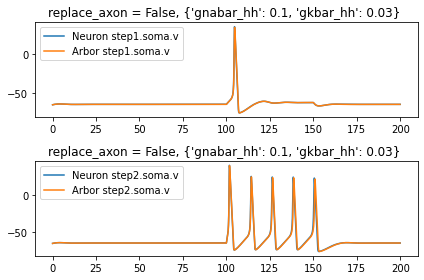

In [15]:
def plot_response_comparison(arb_resp, nrn_resp, title):
    num_steps = len(arb_resp)
    for i, step in enumerate(arb_resp):
        plt.subplot(num_steps, 1, i+1)
        plt.plot(nrn_resp[step]['time'], nrn_resp[step]['voltage'], label='Neuron ' + step)
        plt.plot(arb_resp[step]['time'], arb_resp[step]['voltage'], label='Arbor ' + step)
        plt.title(title)
        plt.legend(loc='upper left')
    plt.tight_layout()


def plot_response_comparison_for(arb_resp, nrn_resp, *key):
    plot_response_comparison(arb_resp[key], nrn_resp[key],
                            'replace_axon = %s, %s ' % (key[0], str(params[key[1]])))

plot_response_comparison_for(arb_responses, nrn_responses, False, 0)

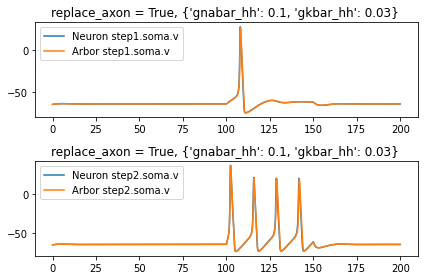

In [16]:
plot_response_comparison_for(arb_responses, nrn_responses, True, 0)

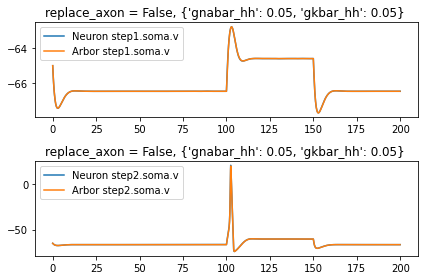

In [17]:
plot_response_comparison_for(arb_responses, nrn_responses, False, 1)

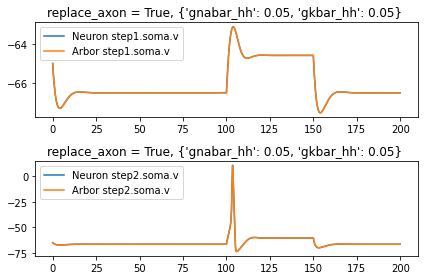

In [18]:
plot_response_comparison_for(arb_responses, nrn_responses, True, 1)

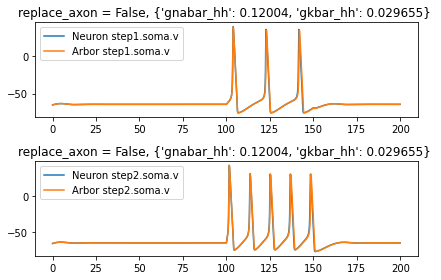

In [19]:
plot_response_comparison_for(arb_responses, nrn_responses, False, 2)

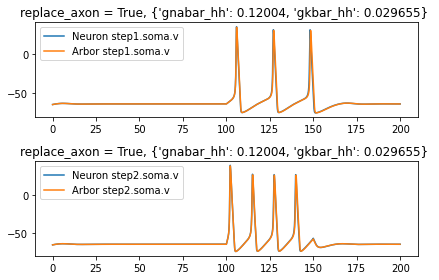

In [20]:
plot_response_comparison_for(arb_responses, nrn_responses, True, 2)

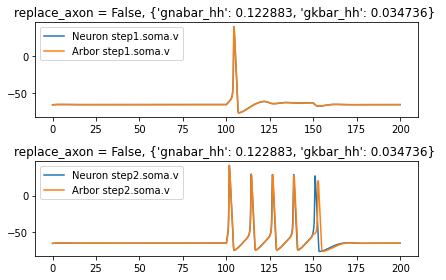

In [21]:
plot_response_comparison_for(arb_responses, nrn_responses, False, 3)

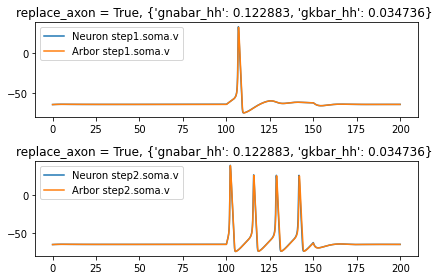

In [22]:
plot_response_comparison_for(arb_responses, nrn_responses, True, 3)

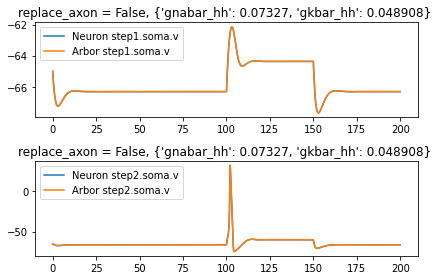

In [23]:
plot_response_comparison_for(arb_responses, nrn_responses, False, 4)

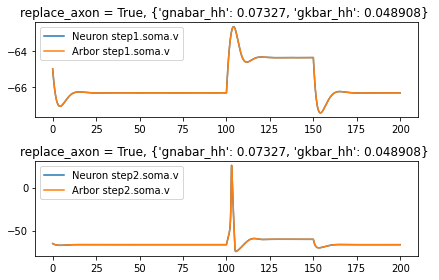

In [24]:
plot_response_comparison_for(arb_responses, nrn_responses, True, 4)

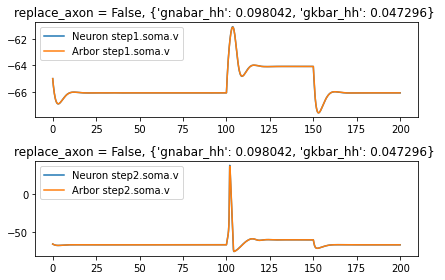

In [25]:
plot_response_comparison_for(arb_responses, nrn_responses, False, 5)

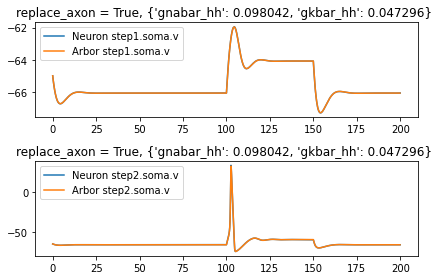

In [26]:
plot_response_comparison_for(arb_responses, nrn_responses, True, 5)

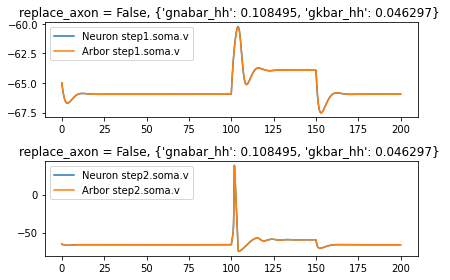

In [27]:
plot_response_comparison_for(arb_responses, nrn_responses, False, 6)

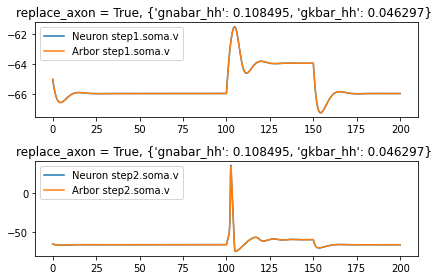

In [28]:
plot_response_comparison_for(arb_responses, nrn_responses, True, 6)

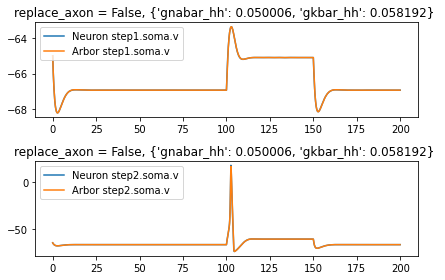

In [29]:
plot_response_comparison_for(arb_responses, nrn_responses, False, 7)

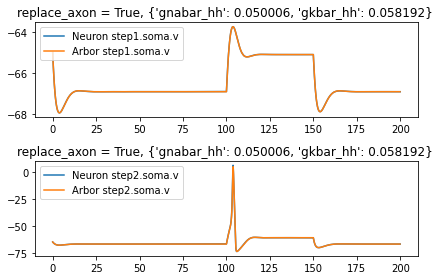

In [30]:
plot_response_comparison_for(arb_responses, nrn_responses, True, 7)

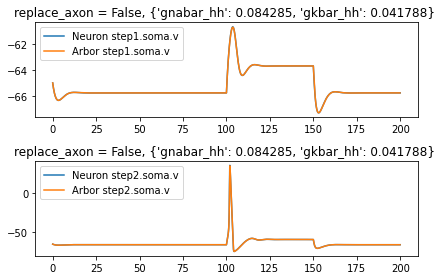

In [31]:
plot_response_comparison_for(arb_responses, nrn_responses, False, 8)

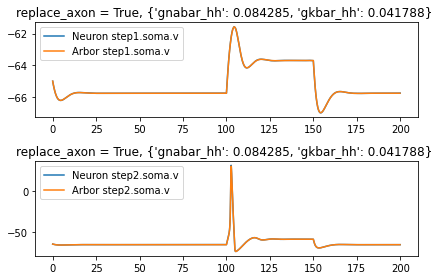

In [32]:
plot_response_comparison_for(arb_responses, nrn_responses, True, 8)

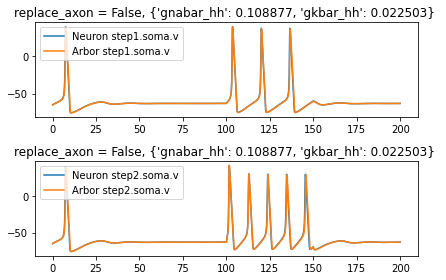

In [33]:
plot_response_comparison_for(arb_responses, nrn_responses, False, 9)

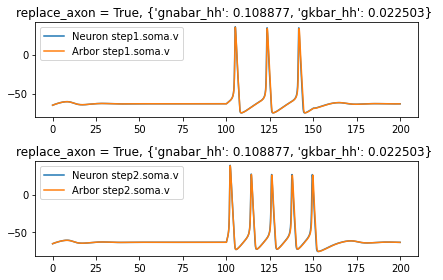

In [34]:
plot_response_comparison_for(arb_responses, nrn_responses, True, 9)

The voltage traces look mostly very similar between Arbor and Neuron with the exception of the last spike in `step2` with the configuration axon replacement `False` and parameter index `3`. We can perform spike time analysis to understand this quantitatively. 

### Spike time cross-validation

To compare Arbor and Neuron voltage traces further, we analyze the spike counts and times with the eFEL library and Arbor's built-in spike detector. Note that while eFEL measures the `peak_time`, Arbor's spike detector as configured above will measure the time when the voltage passes a threshold of -10 mV.

In [35]:
efel_features = ['Spikecount',
                'time_to_first_spike',
                'time_to_second_spike',
                'time_to_last_spike']


# Extract spike observables from protocol simulation responses
def get_spike_data(protocols, do_replace_axon, param_values,
                   arb_resp, nrn_resp):
    spike_res = []

    for step in protocols:
        recording_name = step['recording_name']
        stim_start = step['delay']
        stim_end = stim_start + step['duration']
        
        for efel_feature_name in efel_features:
            # Calculate spike observables with eFEL
            feature_name = '%s.%s' % (step['name'], efel_feature_name)
            feature = ephys.efeatures.eFELFeature(
                        feature_name,
                        efel_feature_name=efel_feature_name,
                        recording_names={'': recording_name},
                        stim_start=stim_start,
                        stim_end=stim_end)

            # Calculate spike observables with Arbor
            try:
                if efel_feature_name == 'Spikecount':
                    arbor_int = len(arb_resp[recording_name]['spikes'])
                elif efel_feature_name == 'time_to_first_spike':
                    arbor_int = arb_resp[recording_name]['spikes'][0]-stim_start
                elif efel_feature_name == 'time_to_second_spike':
                    arbor_int = arb_resp[recording_name]['spikes'][1]-stim_start
                elif efel_feature_name == 'time_to_last_spike':
                    arbor_int = arb_resp[recording_name]['spikes'][-1]-stim_start
            except Exception:
                arbor_int = numpy.nan

            spike_res.append(dict(
                replace_axon=do_replace_axon,
                protocol=step['name'],
                **param_values,
                efel=efel_feature_name,
                Neuron=feature.calculate_feature(nrn_resp),
                Arbor=feature.calculate_feature(arb_resp),
                Arbor_int=arbor_int))
    return spike_res


# Compare spike observables between Arbor and Neuron
def analyze_spikes(spike_res):
    spike_res_df = pandas.DataFrame(spike_res)
    spike_res_df.set_index(
        ['replace_axon', 'protocol',
         'gnabar_hh', 'gkbar_hh', 'efel'], inplace=True)
    spike_res_df.dropna(how='all', inplace=True)  # drop all-NaN rows

    # Arbor to Neuron cross-validation with eFEL
    spike_res_df['abs_diff Arbor to Neuron'] = \
        spike_res_df.apply(
            lambda r: abs(r['Arbor']-r['Neuron']), axis=1)
    spike_res_df['rel_abs_diff Arbor to Neuron [%]'] = \
        spike_res_df.apply(
            lambda r: 100.*abs(r['Arbor']-r['Neuron'])/r['Neuron']
                      if r['Neuron'] != 0 else numpy.nan, axis=1)

    # Cross-validation of eFEL's spike detection with Arbor's
    spike_res_df['abs_diff eFEL to Arbor-internal'] = \
        spike_res_df.apply(
            lambda r: abs(r['Arbor']-r['Arbor_int']), axis=1)
    spike_res_df['rel_abs_diff eFEL to Arbor-internal [%]'] = \
        spike_res_df.apply(
            lambda r: 100.*abs(r['Arbor']-r['Arbor_int'])/r['Arbor_int']
                      if r['Arbor_int'] != 0 else numpy.nan, axis=1)
    return spike_res_df


# Aggregate all simulations into a single data frame 
def joint_spike_analysis(arb_resp, nrn_resp, replace_axon_policies, param_list):
    return pandas.concat(
        [analyze_spikes(get_spike_data(protocol_steps,
                                       replace_axon_policies[key[0]],
                                       param_list[key[1]],
                                       arb_resp[key],
                                       nrn_resp[key]))
         for key in arb_responses], axis=0)


pandas.options.display.float_format = '{:,.3f}'.format
# pandas.options.display.max_rows = None  # uncomment for full view
spike_results = joint_spike_analysis(arb_responses, nrn_responses, replace_axon, params)
spike_results

Neuron  Arbor  \
replace_axon protocol gnabar_hh gkbar_hh efel                                  
False        step1    0.100     0.030    Spikecount             1.000  1.000   
                                         time_to_first_spike    4.700  4.800   
                                         time_to_last_spike     4.700  4.800   
             step2    0.100     0.030    Spikecount             5.000  5.000   
                                         time_to_first_spike    1.700  1.800   
...                                                               ...    ...   
True         step1    0.109     0.023    time_to_last_spike    41.600 41.800   
             step2    0.109     0.023    Spikecount             5.000  5.000   
                                         time_to_first_spike    2.200  2.200   
                                         time_to_second_spike  14.300 14.400   
                                         time_to_last_spike    49.400 49.700   

                                                               Arbor_int  \
replace_axon protocol gnabar_hh gkbar_hh efel                              
False        step1    0.100     0.030    Spikecount                1.000   
                                         time_to_first_spike       4.417   
                                         time_to_last_spike        4.417   
             step2    0.100     0.030    Spikecount                5.000   
                                         time_to_first_spike       1.456   
...                                                                  ...   
True         step1    0.109     0.023    time_to_last_spike       41.437   
             step2    0.109     0.023    Spikecount                5.000   
                                         time_to_first_spike       1.813   
                                         time_to_second_spike     13.967   
                                         time_to_last_spike       49.274   

                                                               abs_diff Arbor to Neuron  \
replace_axon protocol gnabar_hh gkbar_hh efel                                             
False        step1    0.100     0.030    Spikecount                               0.000   
                                         time_to_first_spike                      0.100   
                                         time_to_last_spike                       0.100   
             step2    0.100     0.030    Spikecount                               0.000   
                                         time_to_first_spike                      0.100   
...                                                                                 ...   
True         step1    0.109     0.023    time_to_last_spike                       0.200   
             step2    0.109     0.023    Spikecount                               0.000   
                                         time_to_first_spike                      0.000   
                                         time_to_second_spike                     0.100   
                                         time_to_last_spike                       0.300   

                                                               rel_abs_diff Arbor to Neuron [%]  \
replace_axon protocol gnabar_hh gkbar_hh efel                                                     
False        step1    0.100     0.030    Spikecount                                       0.000   
                                         time_to_first_spike                              2.128   
                                         time_to_last_spike                               2.128   
             step2    0.100     0.030    Spikecount                                       0.000   
                                         time_to_first_spike                              5.882   
...                                                                                         ...   
True         step1    0.109     0.023    time_to_last_spi

To understand the deviations over the entire parameter set and different axon replacement policies, we explore the per eFEL-observable statistics. `Spikecount`s are fully consistent between Arbor and Neuron, whereas `time_to_last_spike` shows a max 1.8 ms.

In [36]:
spike_results[['abs_diff Arbor to Neuron',
               'rel_abs_diff Arbor to Neuron [%]']].groupby('efel').describe()

abs_diff Arbor to Neuron                                \
                                        count  mean   std   min   25%   50%   
efel                                                                          
Spikecount                             40.000 0.000 0.000 0.000 0.000 0.000   
time_to_first_spike                    28.000 0.068 0.061 0.000 0.000 0.100   
time_to_last_spike                     40.000 0.147 0.295 0.000 0.000 0.100   
time_to_second_spike                   12.000 0.117 0.039 0.100 0.100 0.100   

                                 rel_abs_diff Arbor to Neuron [%]              \
                       75%   max                            count  mean   std   
efel                                                                            
Spikecount           0.000 0.000                           28.000 0.000 0.000   
time_to_first_spike  0.100 0.200                           28.000 1.827 2.160   
time_to_last_spike   0.200 1.800                           28.000 1.560 1.733   
time_to_second_spike 0.100 0.200                           12.000 1.326 1.675   

                                                     
                        min   25%   50%   75%   max  
efel                                                 
Spikecount            0.000 0.000 0.000 0.000 0.000  
time_to_first_spike  -0.216 0.000 1.350 3.005 6.250  
time_to_last_spike    0.000 0.480 0.719 2.458 5.556  
time_to_second_spike  0.427 0.659 0.699 0.775 6.250

If we inspect the traces with highest difference in `time_to_last_spike`, we find that there is a single outlier, consistent with the plot above (axon replacement `False`, parameter index `3`).

In [37]:
spike_results[ [el[spike_results.index.names.index('efel')] == 'time_to_last_spike'
                for el in spike_results.index] ].sort_values(
                by='abs_diff Arbor to Neuron', ascending=False).head(5)

,,,,,Neuron,Arbor,Arbor_int,abs_diff Arbor to Neuron,rel_abs_diff Arbor to Neuron [%],abs_diff eFEL to Arbor-internal,rel_abs_diff eFEL to Arbor-internal [%]
replace_axon,protocol,gnabar_hh,gkbar_hh,efel,,,,,,,
False,step2,0.123,0.035,time_to_last_spike,51.000,52.800,52.500,1.800,3.529,0.300,0.572
True,step1,0.120,0.030,time_to_last_spike,48.100,48.500,48.086,0.400,0.832,0.414,0.861
False,step2,0.100,0.030,time_to_last_spike,50.600,51.000,50.622,0.400,0.791,0.378,0.747
True,step2,0.109,0.023,time_to_last_spike,49.400,49.700,49.274,0.300,0.607,0.426,0.865
False,step1,0.120,0.030,time_to_last_spike,41.700,42.000,41.702,0.300,0.719,0.298,0.716


For the spike times, we find the anticipated bias between eFEL and Arbor's internal spike detector.

In [38]:
spike_results[['abs_diff eFEL to Arbor-internal',
               'rel_abs_diff eFEL to Arbor-internal [%]']].groupby('efel').describe()

abs_diff eFEL to Arbor-internal                          \
                                               count  mean   std   min   25%   
efel                                                                           
Spikecount                                    40.000 0.000 0.000 0.000 0.000   
time_to_first_spike                           28.000 0.347 0.038 0.265 0.327   
time_to_last_spike                            28.000 0.349 0.044 0.265 0.308   
time_to_second_spike                          12.000 0.373 0.039 0.292 0.358   

                                        \
                       50%   75%   max   
efel                                     
Spikecount           0.000 0.000 0.000   
time_to_first_spike  0.350 0.374 0.443   
time_to_last_spike   0.350 0.379 0.426   
time_to_second_spike 0.374 0.387 0.434   

                     rel_abs_diff eFEL to Arbor-internal [%]               \
                                                       count   mean   std   
efel                                                                        
Spikecount                                            28.000  0.000 0.000   
time_to_first_spike                                   28.000 13.602 6.836   
time_to_last_spike                                    28.000  7.814 7.185   
time_to_second_spike                                  12.000  5.196 7.745   

                                                        
                        min   25%    50%    75%    max  
efel                                                    
Spikecount            0.000 0.000  0.000  0.000  0.000  
time_to_first_spike  -0.381 8.551 14.255 19.162 24.861  
time_to_last_spike    0.572 0.864  6.783 14.181 21.150  
time_to_second_spike  1.286 2.193  2.554  2.928 28.464

### Running protocols with a finer time step

To rule out the discretization as a possible source of the above error in `time_to_last_spike`, we can re-run the simulations at a smaller `dt` of 0.001 ms (default is 0.025 ms).

In [39]:
arb_responses_fine_dt, nrn_responses_fine_dt = run_all_simulations(replace_axon, params, dt=0.001)

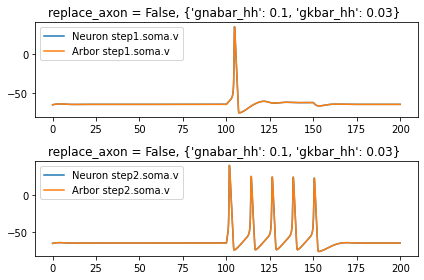

In [40]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, False, 0)

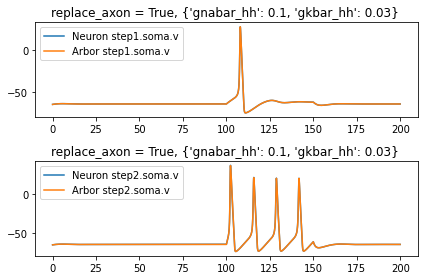

In [41]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, True, 0)

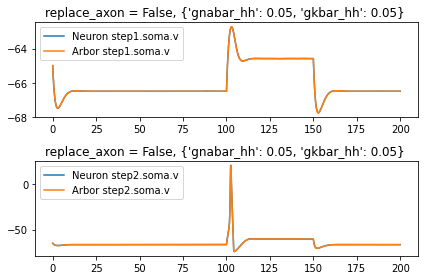

In [42]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, False, 1)

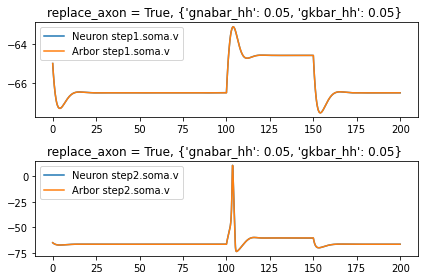

In [43]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, True, 1)

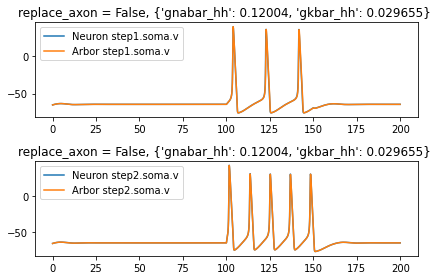

In [44]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, False, 2)

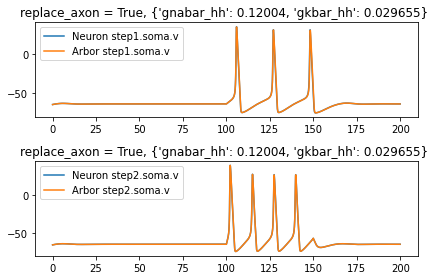

In [45]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, True, 2)

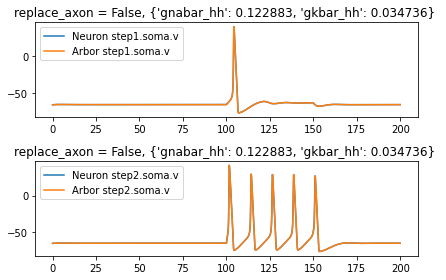

In [46]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, False, 3)

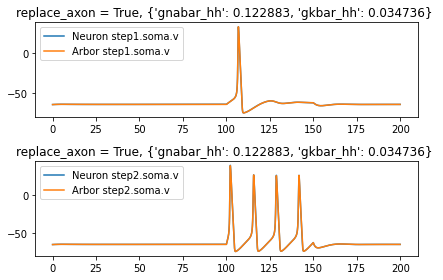

In [47]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, True, 3)

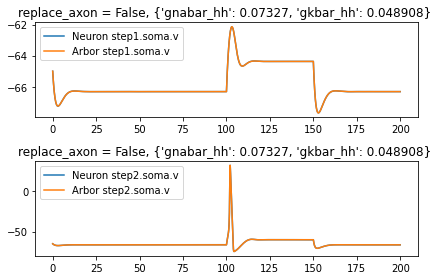

In [48]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, False, 4)

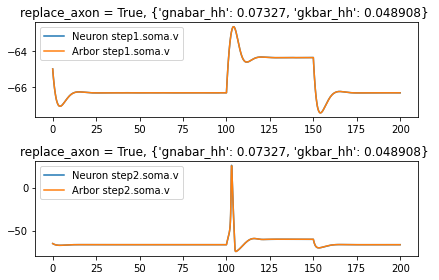

In [49]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, True, 4)

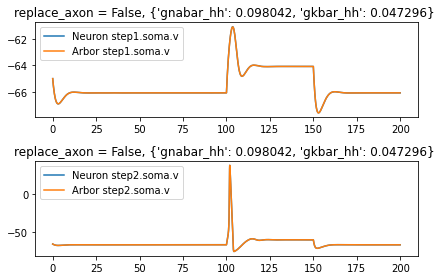

In [50]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, False, 5)

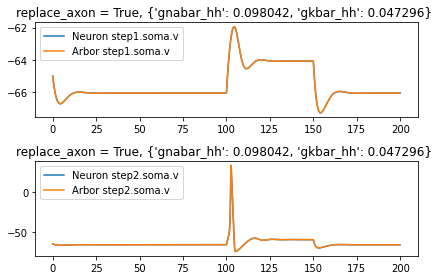

In [51]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, True, 5)

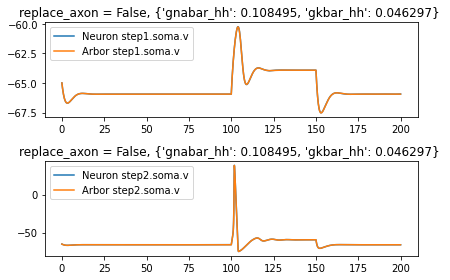

In [52]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, False, 6)

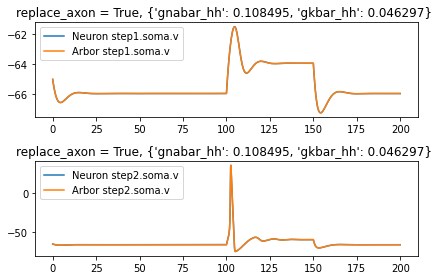

In [53]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, True, 6)

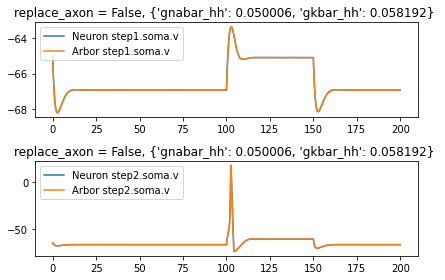

In [54]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, False, 7)

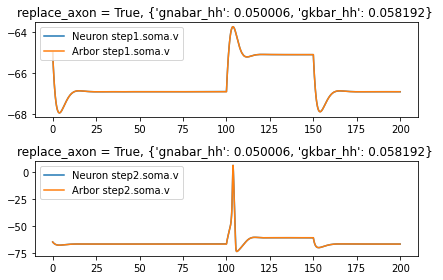

In [55]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, True, 7)

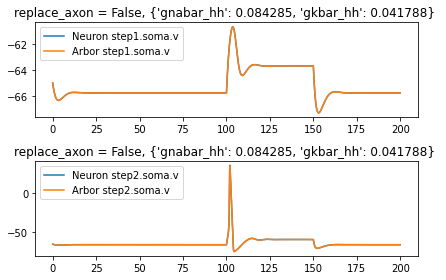

In [56]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, False, 8)

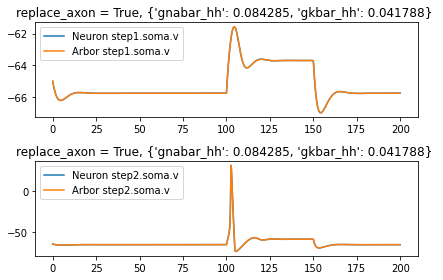

In [57]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, True, 8)

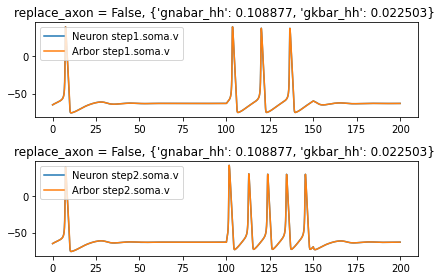

In [58]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, False, 9)

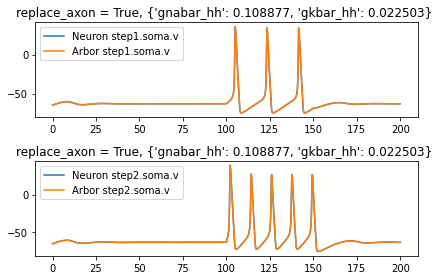

In [59]:
plot_response_comparison_for(arb_responses_fine_dt, nrn_responses_fine_dt, True, 9)

In [60]:
spike_results_fine_dt = joint_spike_analysis(arb_responses_fine_dt, nrn_responses_fine_dt, replace_axon, params)
spike_results_fine_dt

Neuron  Arbor  \
replace_axon protocol gnabar_hh gkbar_hh efel                                  
False        step1    0.100     0.030    Spikecount             1.000  1.000   
                                         time_to_first_spike    4.700  4.700   
                                         time_to_last_spike     4.700  4.700   
             step2    0.100     0.030    Spikecount             5.000  5.000   
                                         time_to_first_spike    1.700  1.700   
...                                                               ...    ...   
True         step1    0.109     0.023    time_to_last_spike    41.600 41.700   
             step2    0.109     0.023    Spikecount             5.000  5.000   
                                         time_to_first_spike    2.200  2.200   
                                         time_to_second_spike  14.300 14.300   
                                         time_to_last_spike    49.400 49.400   

                                                               Arbor_int  \
replace_axon protocol gnabar_hh gkbar_hh efel                              
False        step1    0.100     0.030    Spikecount                1.000   
                                         time_to_first_spike       4.372   
                                         time_to_last_spike        4.372   
             step2    0.100     0.030    Spikecount                5.000   
                                         time_to_first_spike       1.442   
...                                                                  ...   
True         step1    0.109     0.023    time_to_last_spike       41.290   
             step2    0.109     0.023    Spikecount                5.000   
                                         time_to_first_spike       1.800   
                                         time_to_second_spike     13.903   
                                         time_to_last_spike       49.057   

                                                               abs_diff Arbor to Neuron  \
replace_axon protocol gnabar_hh gkbar_hh efel                                             
False        step1    0.100     0.030    Spikecount                               0.000   
                                         time_to_first_spike                      0.000   
                                         time_to_last_spike                       0.000   
             step2    0.100     0.030    Spikecount                               0.000   
                                         time_to_first_spike                      0.000   
...                                                                                 ...   
True         step1    0.109     0.023    time_to_last_spike                       0.100   
             step2    0.109     0.023    Spikecount                               0.000   
                                         time_to_first_spike                      0.000   
                                         time_to_second_spike                     0.000   
                                         time_to_last_spike                       0.000   

                                                               rel_abs_diff Arbor to Neuron [%]  \
replace_axon protocol gnabar_hh gkbar_hh efel                                                     
False        step1    0.100     0.030    Spikecount                                       0.000   
                                         time_to_first_spike                              0.000   
                                         time_to_last_spike                               0.000   
             step2    0.100     0.030    Spikecount                                       0.000   
                                         time_to_first_spike                              0.000   
...                                                                                         ...   
True         step1    0.109     0.023    time_to_last_spi

In [61]:
spike_results_fine_dt[['abs_diff Arbor to Neuron',
                       'rel_abs_diff Arbor to Neuron [%]']].groupby('efel').describe()

abs_diff Arbor to Neuron                                \
                                        count  mean   std   min   25%   50%   
efel                                                                          
Spikecount                             40.000 0.000 0.000 0.000 0.000 0.000   
time_to_first_spike                    28.000 0.014 0.036 0.000 0.000 0.000   
time_to_last_spike                     40.000 0.025 0.049 0.000 0.000 0.000   
time_to_second_spike                   12.000 0.017 0.039 0.000 0.000 0.000   

                                 rel_abs_diff Arbor to Neuron [%]              \
                       75%   max                            count  mean   std   
efel                                                                            
Spikecount           0.000 0.000                           28.000 0.000 0.000   
time_to_first_spike  0.000 0.100                           28.000 0.329 1.248   
time_to_last_spike   0.000 0.200                           28.000 0.402 1.233   
time_to_second_spike 0.000 0.100                           12.000 0.067 0.158   

                                                     
                        min   25%   50%   75%   max  
efel                                                 
Spikecount            0.000 0.000 0.000 0.000 0.000  
time_to_first_spike  -0.108 0.000 0.000 0.000 5.263  
time_to_last_spike    0.000 0.000 0.000 0.225 5.263  
time_to_second_spike  0.000 0.000 0.000 0.000 0.439

The outlier in `time_to_last_spike` is gone now, both visually and quantitatively.

In [62]:
spike_results_fine_dt[ [el[spike_results_fine_dt.index.names.index('efel')] == 'time_to_last_spike'
                        for el in spike_results_fine_dt.index] ].sort_values(
                        by='abs_diff Arbor to Neuron', ascending=False).head(5)

Neuron  Arbor  \
replace_axon protocol gnabar_hh gkbar_hh efel                                
True         step1    0.120     0.030    time_to_last_spike  48.100 48.300   
                      0.109     0.023    time_to_last_spike  41.600 41.700   
False        step2    0.050     0.050    time_to_last_spike   2.400  2.500   
             step1    0.120     0.030    time_to_last_spike  41.700 41.800   
True         step2    0.100     0.030    time_to_last_spike  41.700 41.800   

                                                             Arbor_int  \
replace_axon protocol gnabar_hh gkbar_hh efel                            
True         step1    0.120     0.030    time_to_last_spike     47.892   
                      0.109     0.023    time_to_last_spike     41.290   
False        step2    0.050     0.050    time_to_last_spike      2.142   
             step1    0.120     0.030    time_to_last_spike     41.524   
True         step2    0.100     0.030    time_to_last_spike     41.398   

                                                             abs_diff Arbor to Neuron  \
replace_axon protocol gnabar_hh gkbar_hh efel                                           
True         step1    0.120     0.030    time_to_last_spike                     0.200   
                      0.109     0.023    time_to_last_spike                     0.100   
False        step2    0.050     0.050    time_to_last_spike                     0.100   
             step1    0.120     0.030    time_to_last_spike                     0.100   
True         step2    0.100     0.030    time_to_last_spike                     0.100   

                                                             rel_abs_diff Arbor to Neuron [%]  \
replace_axon protocol gnabar_hh gkbar_hh efel                                                   
True         step1    0.120     0.030    time_to_last_spike                             0.416   
                      0.109     0.023    time_to_last_spike                             0.240   
False        step2    0.050     0.050    time_to_last_spike                             4.167   
             step1    0.120     0.030    time_to_last_spike                             0.240   
True         step2    0.100     0.030    time_to_last_spike                             0.240   

                                                             abs_diff eFEL to Arbor-internal  \
replace_axon protocol gnabar_hh gkbar_hh efel                                                  
True         step1    0.120     0.030    time_to_last_spike                            0.408   
                      0.109     0.023    time_to_last_spike                            0.410   
False        step2    0.050     0.050    time_to_last_spike                            0.358   
             step1    0.120     0.030    time_to_last_spike                            0.276   
True         step2    0.100     0.030    time_to_last_spike                            0.402   

                                                             rel_abs_diff eFEL to Arbor-internal [%]  
replace_axon protocol gnabar_hh gkbar_hh efel                                                         
True         step1    0.120     0.030    time_to_last_spike                                    0.853  
                      0.109     0.023    time_to_last_spike                                    0.994  
False        step2    0.050     0.050    time_to_last_spike                                   16.694  
             step1    0.120     0.030    time_to_last_spike                                    0.664  
True         step2    0.100     0.030    time_to_last_spike                                    0.970

In [63]:
spike_results_fine_dt[['abs_diff eFEL to Arbor-internal',
                       'rel_abs_diff eFEL to Arbor-internal [%]']].groupby('efel').describe()

abs_diff eFEL to Arbor-internal                          \
                                               count  mean   std   min   25%   
efel                                                                           
Spikecount                                    40.000 0.000 0.000 0.000 0.000   
time_to_first_spike                           28.000 0.325 0.042 0.248 0.299   
time_to_last_spike                            28.000 0.332 0.043 0.248 0.301   
time_to_second_spike                          12.000 0.344 0.043 0.279 0.305   

                                        \
                       50%   75%   max   
efel                                     
Spikecount           0.000 0.000 0.000   
time_to_first_spike  0.327 0.348 0.400   
time_to_last_spike   0.328 0.361 0.410   
time_to_second_spike 0.347 0.375 0.405   

                     rel_abs_diff eFEL to Arbor-internal [%]               \
                                                       count   mean   std   
efel                                                                        
Spikecount                                            28.000  0.000 0.000   
time_to_first_spike                                   28.000 12.913 6.573   
time_to_last_spike                                    28.000  7.507 6.918   
time_to_second_spike                                  12.000  4.382 5.904   

                                                        
                        min   25%    50%    75%    max  
efel                                                    
Spikecount            0.000 0.000  0.000  0.000  0.000  
time_to_first_spike  -0.358 7.820 14.737 18.018 22.566  
time_to_last_spike    0.594 0.884  5.852 14.589 20.832  
time_to_second_spike  1.318 2.052  2.380  2.712 22.101

Furthermore, the mean deviation between Arbor and Neuron for eFEL spike times is significantly reduced.

In [64]:
(spike_results_fine_dt[['abs_diff Arbor to Neuron']].groupby('efel').mean()/\
    spike_results[['abs_diff Arbor to Neuron']].groupby('efel').mean()).rename(
        columns={'abs_diff Arbor to Neuron': 
                 'ratio of mean abs_diff Arbor to Neuron for fine dt vs. default dt'})


,ratio of mean abs_diff Arbor to Neuron for fine dt vs. default dt
efel,
Spikecount,NaN
time_to_first_spike,0.211
time_to_last_spike,0.169
time_to_second_spike,0.143
